In [13]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import string
import joblib

In [2]:
data = pd.read_csv("../csv_file/big_data.csv")

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
nlp = spacy.load('en_core_web_sm')

In [5]:
def preprocess_text(text, use_lemmatization=True):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization (optional)
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

In [6]:
data['processed_text'] = data['headlines'].apply(preprocess_text)

In [7]:
max_features_value = 15000

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=max_features_value)

In [9]:
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_text'].apply(lambda x: ' '.join(x)))

In [10]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, data['outcome'], test_size=0.2, random_state=42)

In [11]:
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty: l1 (Lasso) or l2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1.0, 10.0],  # Inverse of regularization strength
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'class_weight': [None, 'balanced'],  # Weights associated with classes for imbalanced datasets
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300],  # Maximum number of iterations for optimization
    'random_state': [42]  # Seed for reproducibility
}

In [15]:
model = LogisticRegression() 

In [16]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

In [17]:
grid_search.fit(X_train_tfidf, y_train)

C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\soder\applicerad AI\env\Lib\site-packages\sklearn\linear_mode

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'class_weight': [None, 'balanced'],
                         'fit_intercept': [True, False],
                         'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'random_state': [42],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [18]:
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 10.0, 'class_weight': None, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}


In [19]:
best_svm_model = grid_search.best_estimator_

In [20]:
y_pred_best = best_svm_model.predict(X_test_tfidf)

In [21]:
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best}')

Best Model Accuracy: 0.9159642401021711


Text(0.5, 1.0, 'Confusion Matrix')

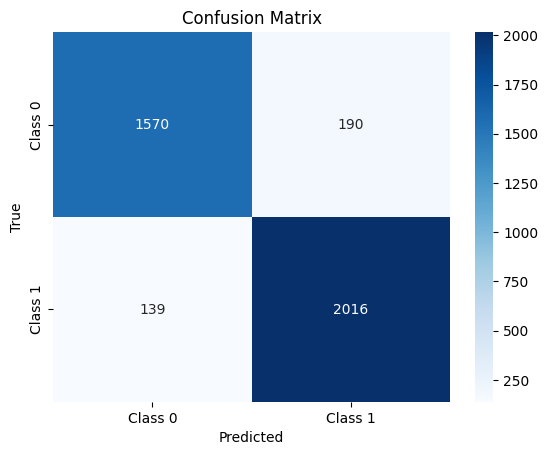

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Create a heatmap of the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [23]:
joblib.dump(best_svm_model, 'logistic_model2.joblib')

['logistic_model2.joblib']